# WUR historical phenotypic wheat data analysis
origin and version of the input file: https://urgi.versailles.inrae.fr/fairdom/data_files/17?version=6

## Load packages, custom functions and data

In [1]:
library(tidyverse)
library(multtest)
library(asreml)

source("../custom_functions.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
  

Offline License checked out Tue Nov 26 18:24:29 2024


Loading ASReml-R version 4.2





Attaching package: ‘BiocGenerics’




The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union




The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union




The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs




The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min




Loading required package: Biobase



Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




Loading required package: Matrix




Attaching package: ‘Matrix’




The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Offline License checked out Fri Nov 22 06:44:35 2024


Loading ASReml-R version 4.2




In [2]:
data_total <- preprocess("WR-Phenotypic-Historical-Wheat-data.xlsx")
write_csv(data_total, "WUR_wheat.csv")
genotypes <- distinct(data_total["accenumb"]) |> rename("genotype" = "accenumb")
cat("Wheat data:\n", nrow(data_total), "observations\n", nrow(genotypes), "genotypes\n", nrow(distinct(data_total["campaign"])), "campaigns\n\n")
summary(data_total[c("days_to_heading", "plant_height", "thousand_kernel_weight")])

Wheat data:
 3093 observations
 2239 genotypes
 21 campaigns



 days_to_heading  plant_height   thousand_kernel_weight
 Min.   :132.0   Min.   : 10.0   Min.   : 21.6         
 1st Qu.:157.0   1st Qu.: 90.0   1st Qu.: 40.2         
 Median :164.0   Median :105.0   Median : 47.1         
 Mean   :164.4   Mean   :107.6   Mean   : 47.8         
 3rd Qu.:170.0   3rd Qu.:125.0   3rd Qu.: 53.5         
 Max.   :214.0   Max.   :180.0   Max.   :126.2         
 NA's   :2299    NA's   :36      NA's   :2030          

## Subset data, remove missing values and singletons, make factors

In [3]:
data_sub_HT <- data_total |> make_data_sub("days_to_heading", 50, 250)
data_sub_PH <- data_total |> make_data_sub("plant_height", 5, 250)
data_sub_TKW <- data_total |> make_data_sub("thousand_kernel_weight", 5, 100)

228 days_to_heading rows kept


1487 plant_height rows kept


50 thousand_kernel_weight rows kept


## Visualise trait values 

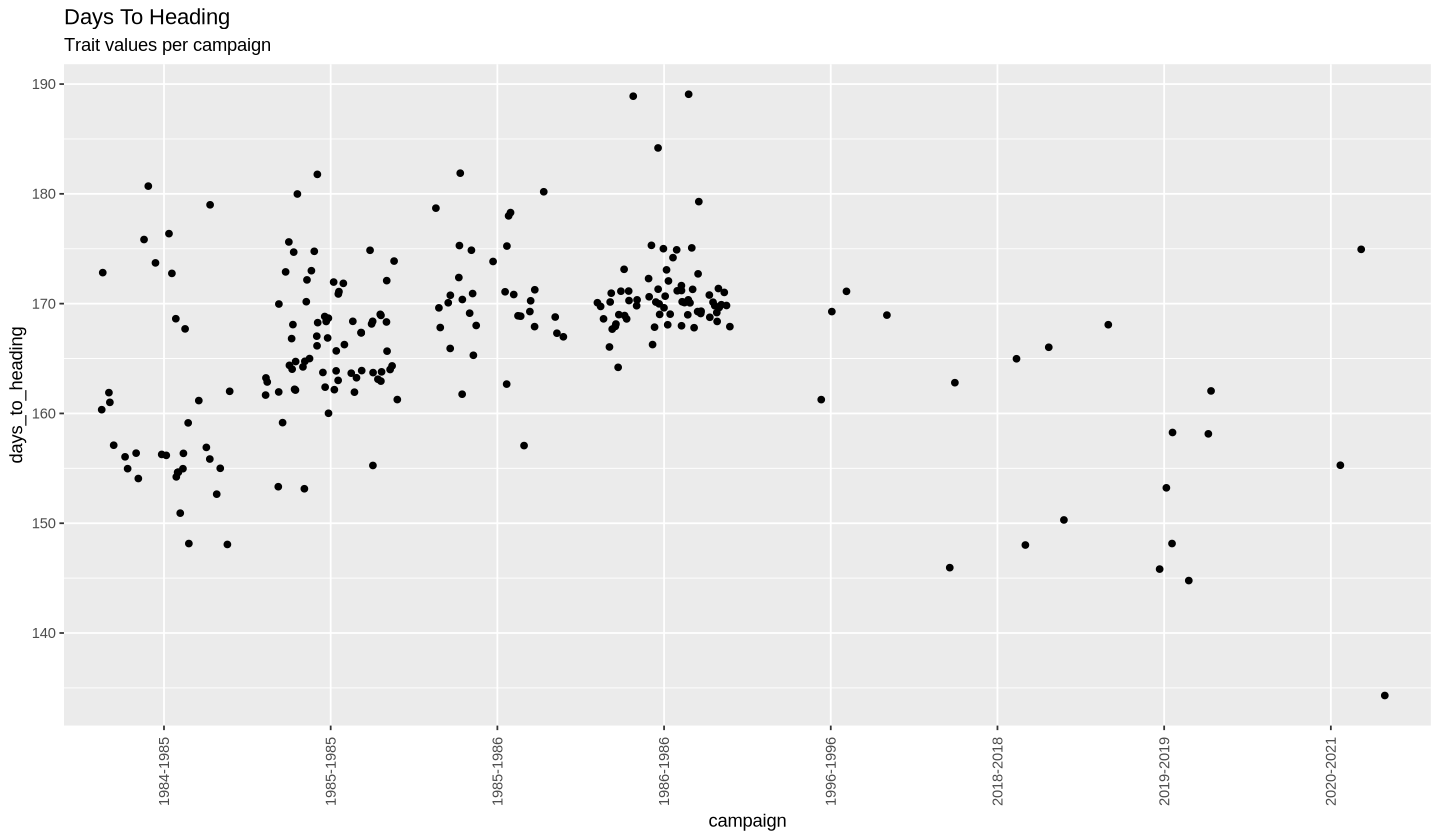

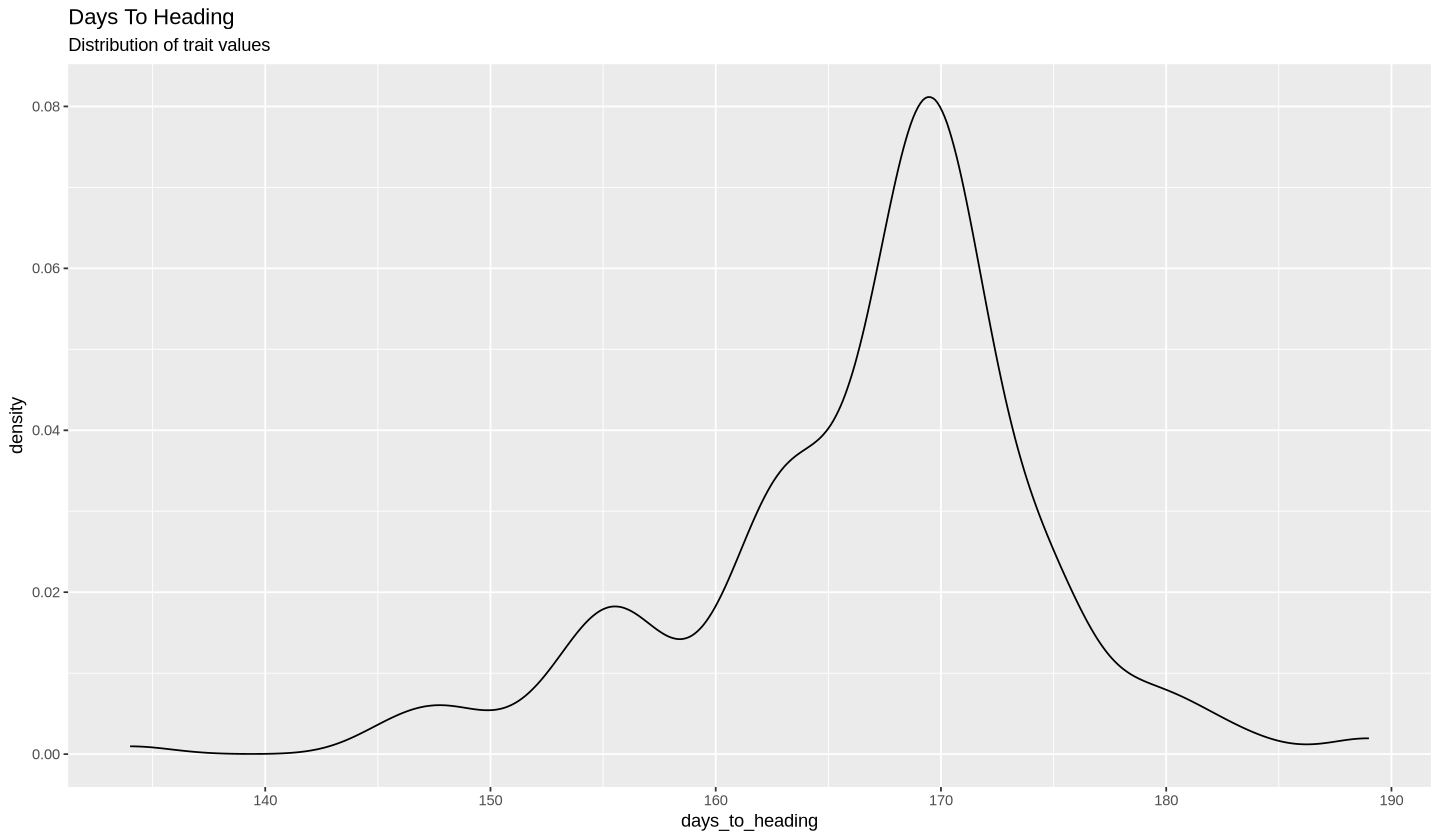

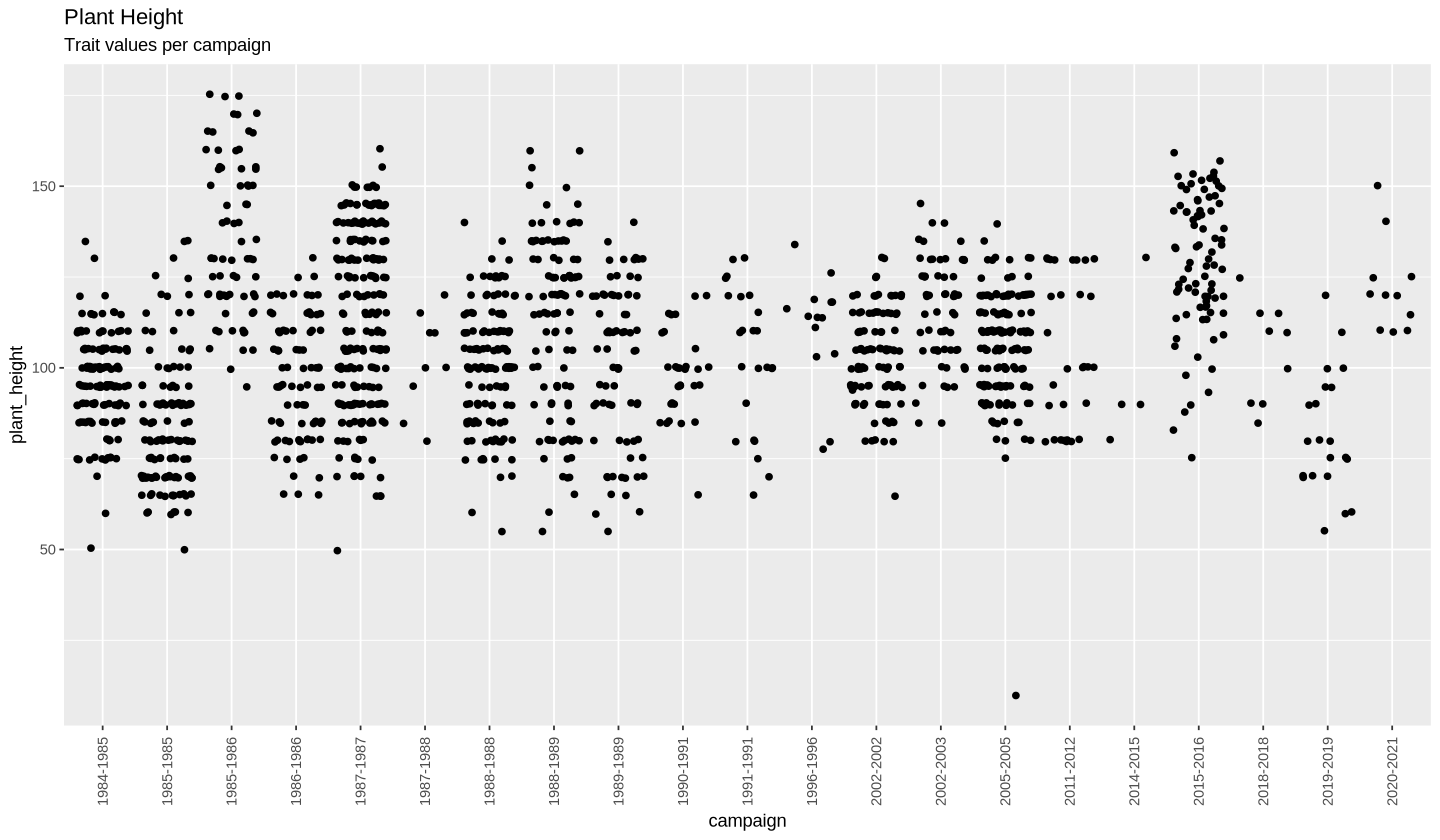

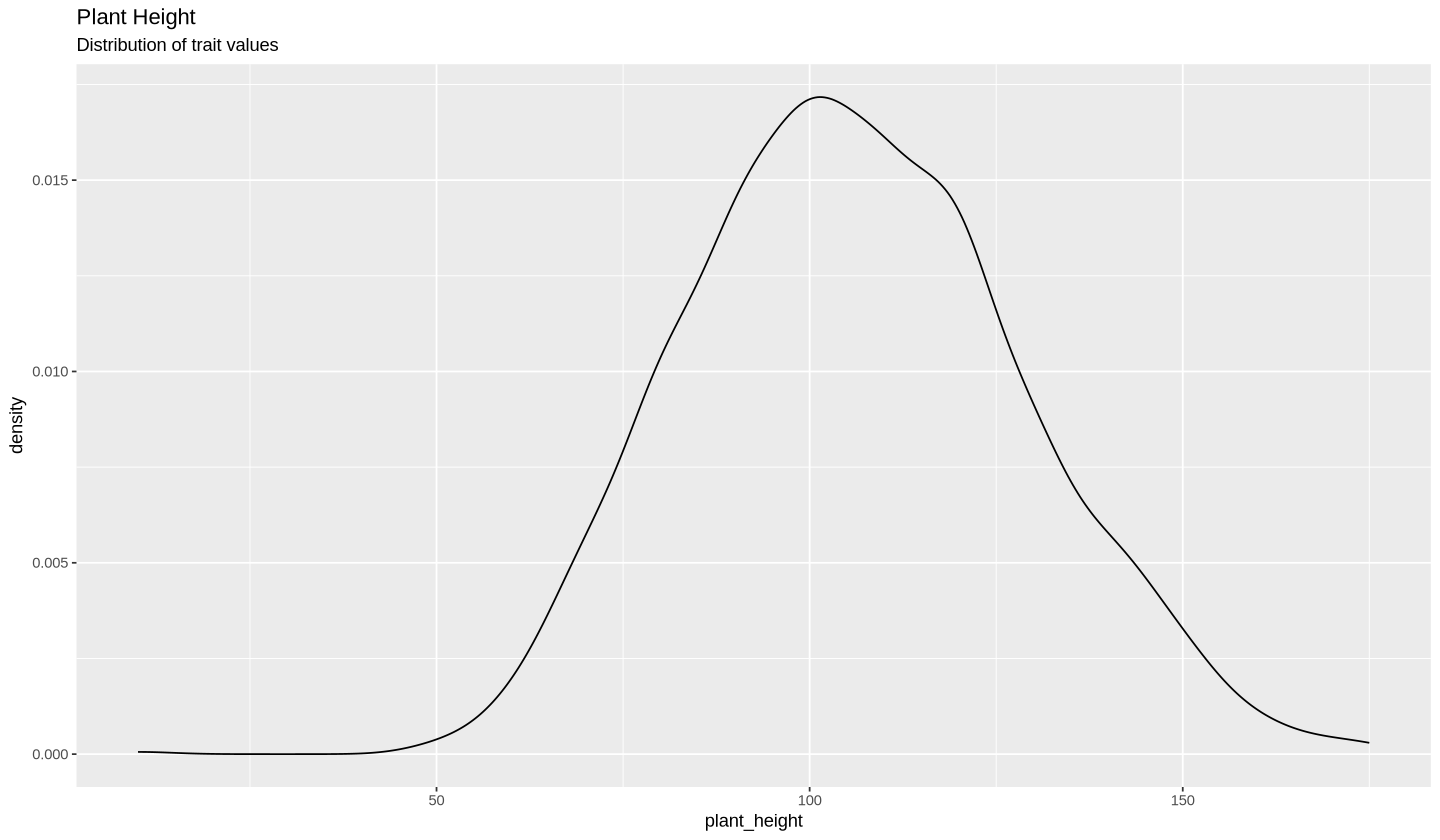

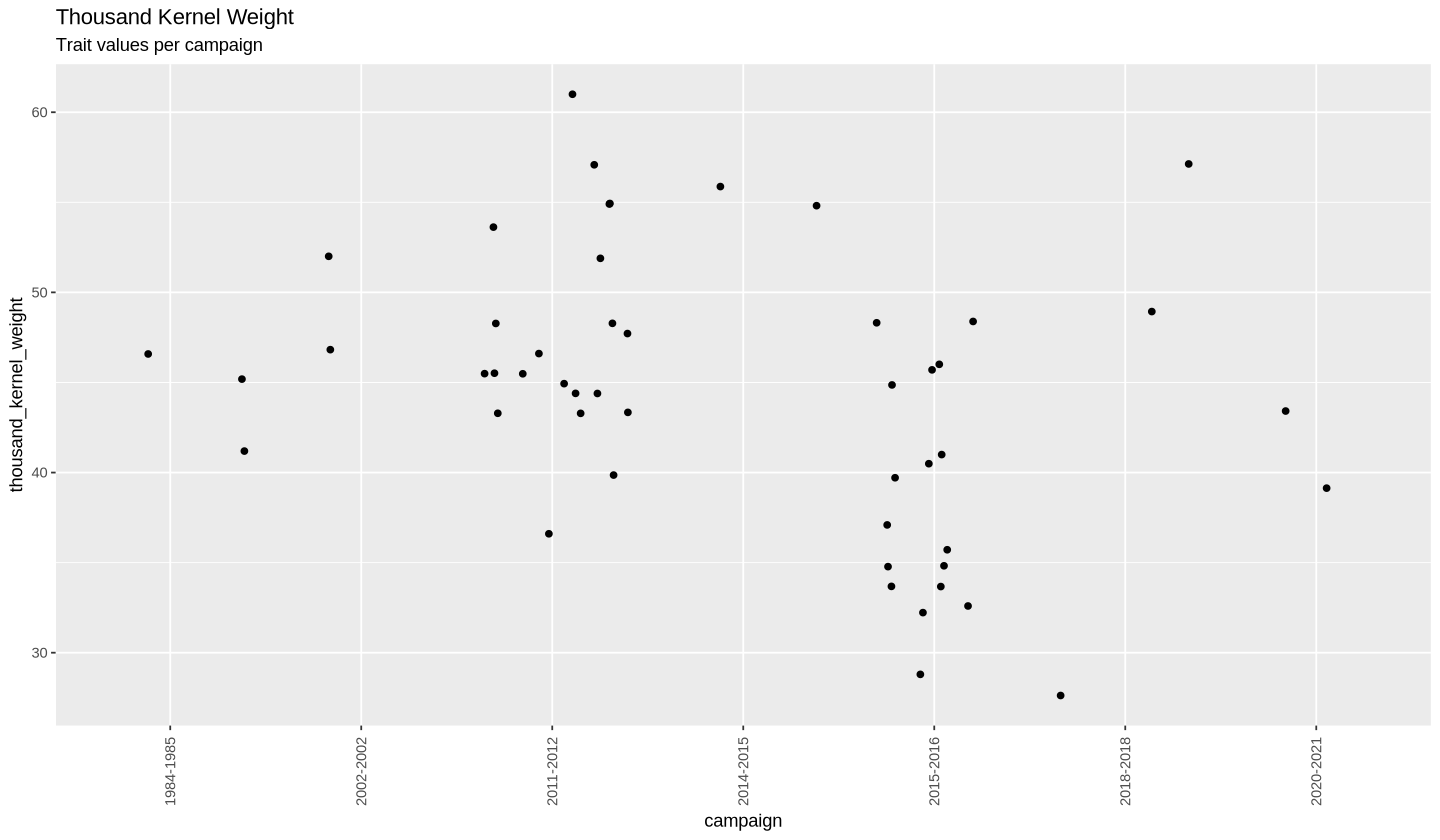

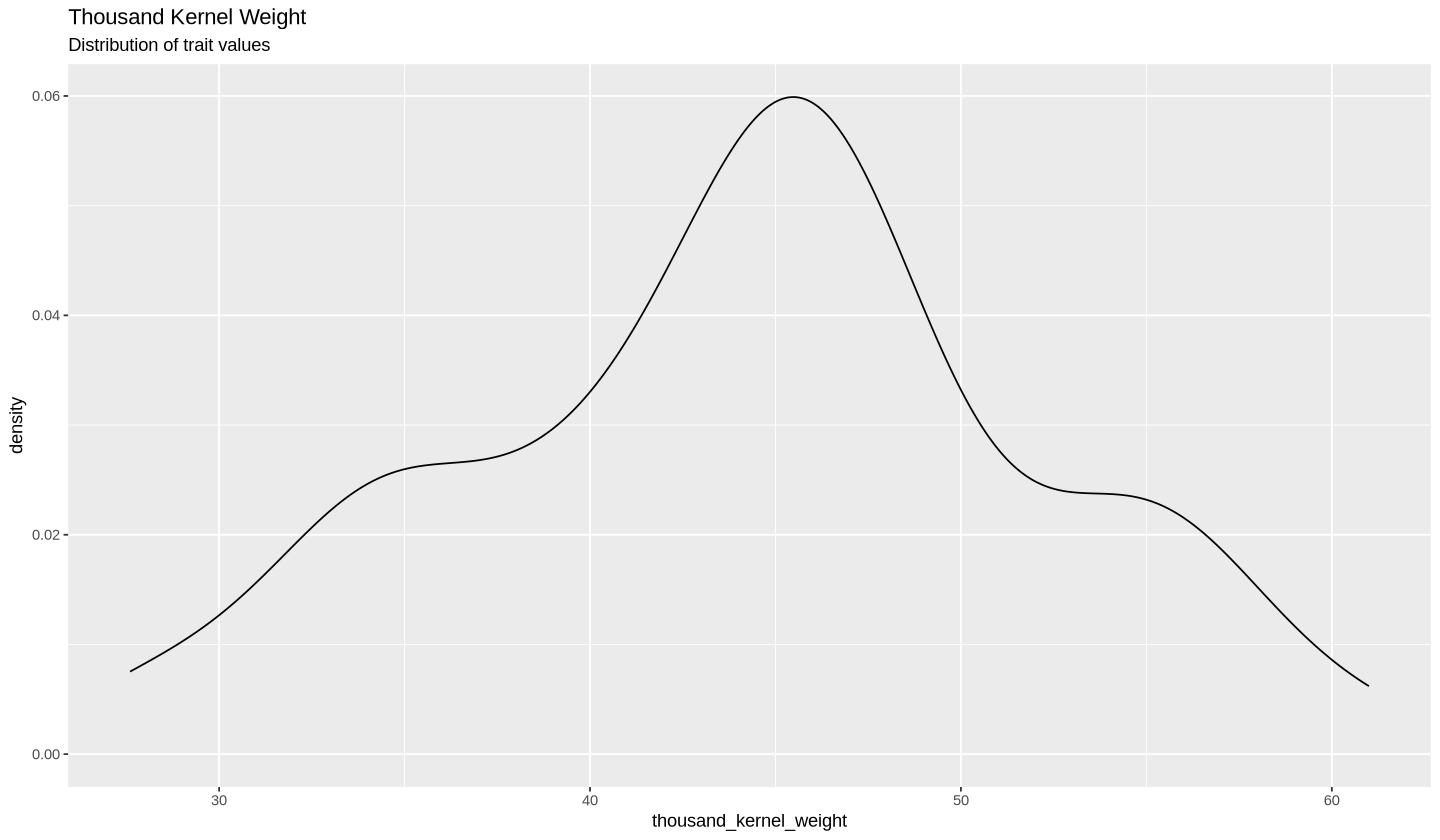

In [4]:
options(repr.plot.width=12, repr.plot.height=7)
data_sub_HT |> visualise_trait(geom_density())
data_sub_PH |> visualise_trait(geom_density())
data_sub_TKW |> visualise_trait(geom_density())

We can see that there are not enough data points for a statistical analysis of the TKW trait.

## Extract and format the campaign effects

In [5]:
asreml_campaign_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                             data = data_sub_HT)

Warning message in asreml(fixed = days_to_heading ~ campaign, random = ~accenumb, :
“Log-likelihood not converged”


Warning message in asreml(fixed = days_to_heading ~ campaign, random = ~accenumb, :
“Some components changed by more than 1% on the last iteration”


In [6]:
asreml_campaign_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_PH)

In [7]:
campaign_effect_HT <- get_campaign_effect(asreml_campaign_HT)
campaign_effect_PH <- get_campaign_effect(asreml_campaign_PH)

## Extract heterogeneous error variances

In [8]:
error_var_HT <- get_error_var(asreml_campaign_HT)
error_var_PH <- get_error_var(asreml_campaign_PH)

## Calculate and standardize the coefficient of variation (CV)

In [9]:
CV_df_HT <- make_CV_df(campaign_effect_HT, error_var_HT)
CV_df_PH <- make_CV_df(campaign_effect_PH, error_var_PH)

## Remove outlier campaigns

In [10]:
data_corrected_HT_I <- data_sub_HT |> correct_I(CV_df_HT)
data_corrected_PH_I <- data_sub_PH |> correct_I(CV_df_PH)

0 outlier campaign(s) detected for trait days_to_heading


0 outlier campaign(s) detected for trait plant_height


## Residuals

In [11]:
asreml_res_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_HT_I)

Warning message in asreml(fixed = days_to_heading ~ accenumb, random = ~campaign, :
“Log-likelihood not converged”


Warning message in asreml(fixed = days_to_heading ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration”


In [12]:
asreml_res_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_PH_I)

60 outlier value(s) detected for trait Days To Heading 


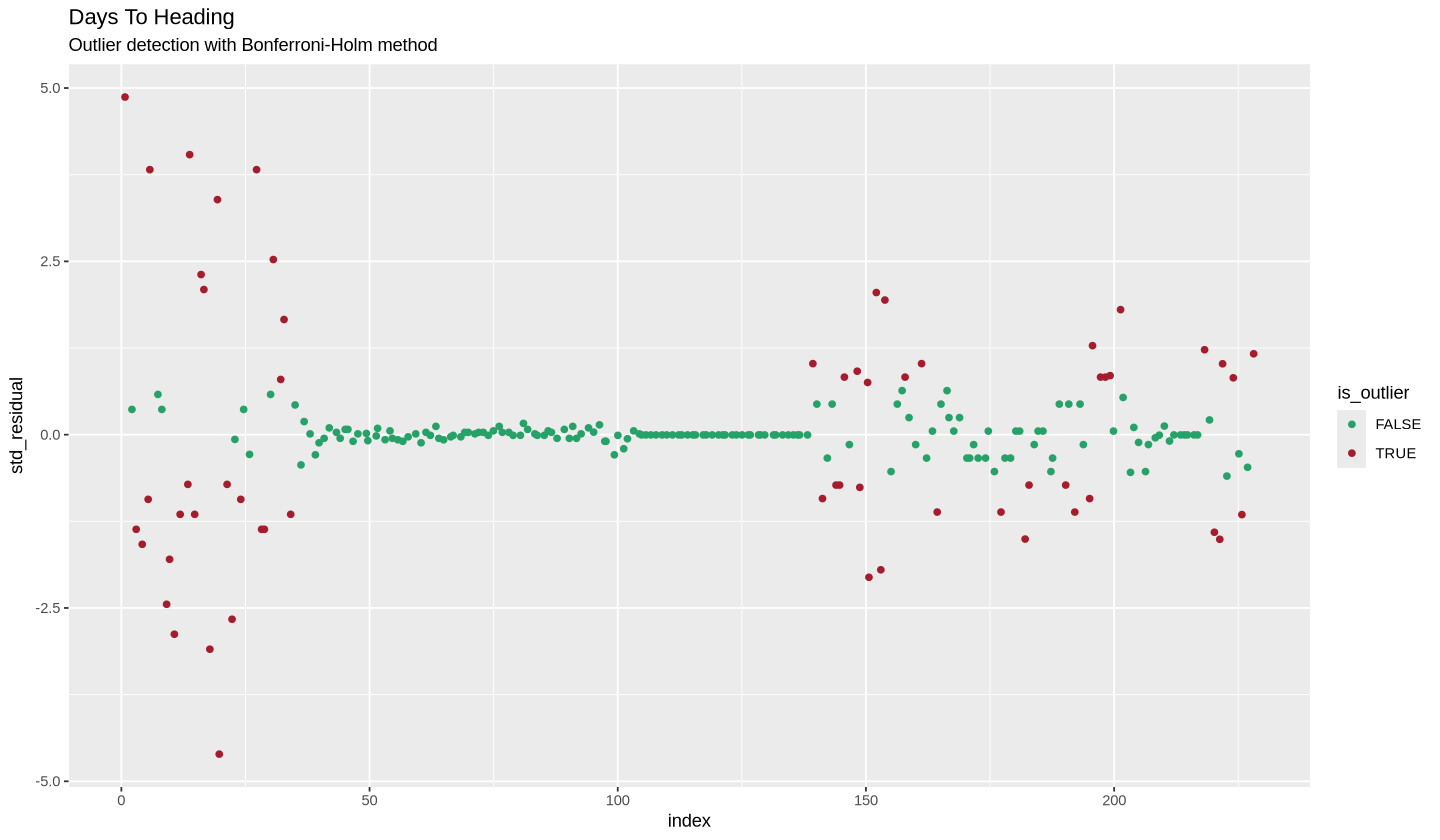

In [13]:
result_BH_HT <- make_BH_multtest(asreml_res_HT)

10 outlier value(s) detected for trait Plant Height 


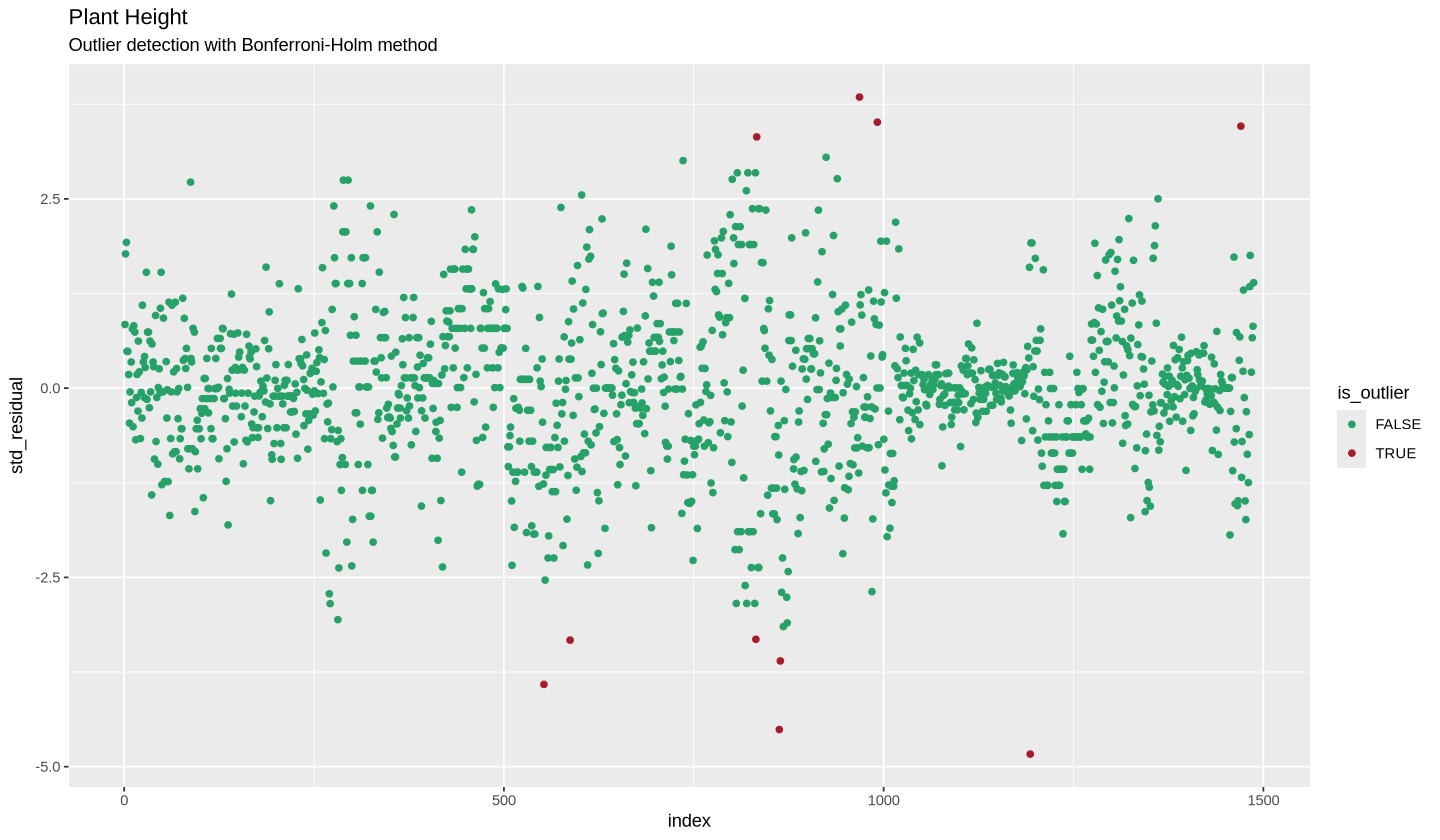

In [14]:
result_BH_PH <- make_BH_multtest(asreml_res_PH)

In [15]:
data_corrected_HT_II <- data_corrected_HT_I |> correct_II(result_BH_HT)
data_corrected_PH_II <- data_corrected_PH_I |> correct_II(result_BH_PH)

In [16]:
data_corrected_all <- bind_rows(
    data_corrected_HT_II,
    data_corrected_PH_II,
    ) |> pivot_longer(cols = !c(accenumb,campaign), names_to = "trait") |>
         drop_na() |> arrange(campaign, accenumb, trait)
write_csv(data_corrected_all, "WUR_wheat_corrected.csv")

## Calculate heritability

In [17]:
asreml_res_h_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_HT_II)

Warning message in asreml(days_to_heading ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Log-likelihood not converged”


Warning message in asreml(days_to_heading ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [18]:
asreml_res_h_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PH_II)

In [19]:
quality_HT <- get_quality(data_sub_HT, asreml_res_h_HT)
quality_PH <- get_quality(data_sub_PH, asreml_res_h_PH)
quality_all <- bind_rows(quality_HT, quality_PH) |> mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_all,"WUR_wheat_data_quality.csv")

days_to_heading heritability: 75 %


plant_height heritability: 69.4 %


## Run linear mixed model with outlier corrected data

In [20]:
asreml_data_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_HT_II)

Warning message in asreml(days_to_heading ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Log-likelihood not converged”


Warning message in asreml(days_to_heading ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [21]:
asreml_data_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PH_II)

## Extract BLUEs and create output file

In [22]:
BLUEs_HT <- get_BLUEs(asreml_data_HT)
BLUEs_PH <- get_BLUEs(asreml_data_PH)

BLUE_all <- genotypes |> 
                        left_join(BLUEs_HT, by="genotype") |> 
                        left_join(BLUEs_PH, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_all,"WUR_wheat_BLUE_values.csv")
summary(BLUE_all)

   genotype         days_to_heading_BLUE plant_height_BLUE
 Length:2239        Min.   :150.3        Min.   : 54.97   
 Class :character   1st Qu.:161.0        1st Qu.: 94.24   
 Mode  :character   Median :162.6        Median :107.23   
                    Mean   :163.1        Mean   :106.60   
                    3rd Qu.:164.5        3rd Qu.:119.51   
                    Max.   :178.0        Max.   :155.43   
                    NA's   :2180         NA's   :1577     

In [23]:
library(rmarkdown)
convert_ipynb("WUR_historic_wheat_data_analysis.ipynb")

In [24]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 24.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/erwan/micromamba/envs/R/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rmarkdown_2.29      asreml_4.2.0.267    Matrix_1.6-5       
 [4] multtest_2.58.0     Biobase_2.62.0      BiocGenerics_0.48.1
 [7] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.1      
[10] dplyr_1.1.4         purrr_1.0.2